<a href="https://colab.research.google.com/github/baranshad/datascienceprojects/blob/main/COVIDprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import io
import requests
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
s=requests.get(url).content
covid=pd.read_csv(io.StringIO(s.decode('utf-8')))

# the columns contians some dates, we neend to handle those special columns

In [2]:
covid.columns ## the columns contians some dates, we neend to handle those special columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '3/3/22', '3/4/22', '3/5/22', '3/6/22', '3/7/22', '3/8/22', '3/9/22',
       '3/10/22', '3/11/22', '3/12/22'],
      dtype='object', length=793)

# Look at the data head

In [4]:
covid.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/3/22,3/4/22,3/5/22,3/6/22,3/7/22,3/8/22,3/9/22,3/10/22,3/11/22,3/12/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,199,199,199,199,203,204,205,208,208,208
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,645,650,650,650,653,656,657,657,662,662
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,94,94,94,94,94,94,94,94,94,94
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,99,99,99,99,99,99,99,100,100,100
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,221,221,221,221,223,227,227,227,227,227


# Drop some redundant variables we are not focus on 

In [5]:
covid_provice = covid.drop(['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key'], axis=1)

In [6]:
covid_num = covid_provice.drop(['Province_State','Population'], axis=1)

# Sum up all the number of events for each day 

In [7]:
covid_num = covid_num.sum(axis=0)

In [8]:
!pip install statsmodels --upgrade
!pip install -q neuralprophet
!pip install mplcyberpunk
!pip install neuralprophet

     |████████████████████████████████| 9.8 MB 5.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 73 kB 1.6 MB/s 
     |████████████████████████████████| 172 kB 17.7 MB/s 


In [9]:
import numpy as np
import requests
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from pandas_datareader import data
import datetime as dt
import urllib.request, json 
import os
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import mplcyberpunk
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [10]:
covid_num.shape

(781,)

In [11]:
covid_daily = covid_num.diff(periods=1)

In [12]:
covid_daily.head()

1/22/20    NaN
1/23/20    0.0
1/24/20    0.0
1/25/20    0.0
1/26/20    0.0
dtype: float64

In [72]:
covidd = pd.Series(covid_daily,name="nums").to_frame()
covidd.dropna()
print(covid.shape)
covidd = covidd.iloc[51:760 ,] ## remove those top rows which contians missing values, select the peroid from 1/22/20 to 2/19/22 
print(covidd.tail())

(3342, 793)
           nums
2/15/22  2598.0
2/16/22  3177.0
2/17/22  2888.0
2/18/22  2474.0
2/19/22   639.0


# The following plot of death by days is very flucturating in a small 7-day time windows, the red line (rolling average) is more smooth, and it clearly present the main trend

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


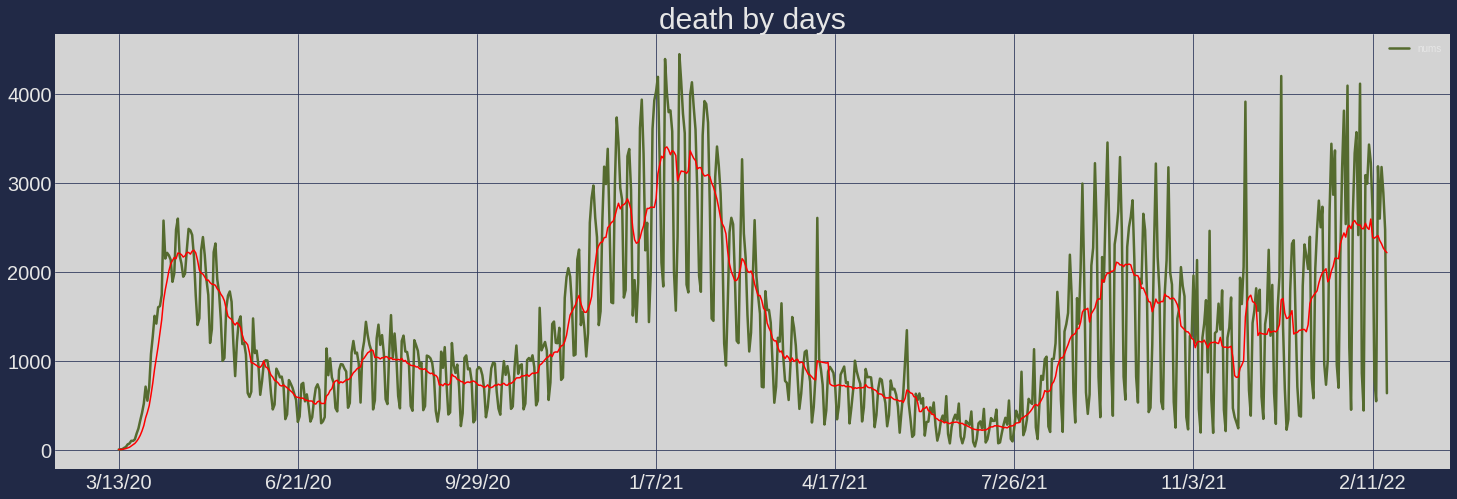

In [73]:
covidma= covidd["nums"].rolling(7, min_periods=1).mean() ## add the moving average line to show the treand 
plt.style.use("cyberpunk")
_ = covidd.plot(style='', figsize=(25,8), color="darkolivegreen", lw=2.5)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.title("death by days", fontdict={'fontsize': 30})
plt.plot(covidma, 'k-', lw=1.5, color='red')

In [74]:
covidd.reset_index(inplace=True)

In [67]:
covidd.head()

,index,nums
0,3/13/20,7.0
1,3/14/20,9.0
2,3/15/20,11.0
3,3/16/20,25.0
4,3/17/20,36.0


In [75]:
covidd['index']= pd.to_datetime(covidd['index']) 

In [76]:
covidd.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   709 non-null    datetime64[ns]
 1   nums    709 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.2 KB


In [98]:
data = covidd.groupby([pd.Grouper(key='index')]).first().reset_index()
data = data.set_index('index')
split_date = '05-Feb-2022'
data_train = data.loc[data.index <= split_date].copy() # using the split date to split train and test data 
data_test = data.loc[(data.index > split_date)].copy()
data_train = data_train.reset_index().rename(columns={'index':'ds', 'nums':'y'}) ## rename those two columns as the names are specifiend as the input of the following models 
data_test = data_test.reset_index().rename(columns={'index':'ds', 'nums':'y'})
data_train['ds'] = data_train['ds'].dt.tz_localize(None) # do not specify the target time zone 
data_test['ds'] = data_test['ds'].dt.tz_localize(None)

In [99]:
print(data_train.shape)
print(data_test.shape)

(695, 2)
(14, 2)


# build up the Prophet model, and present the predcited numbers on the test data versus the actial death numbers 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'death prediction')

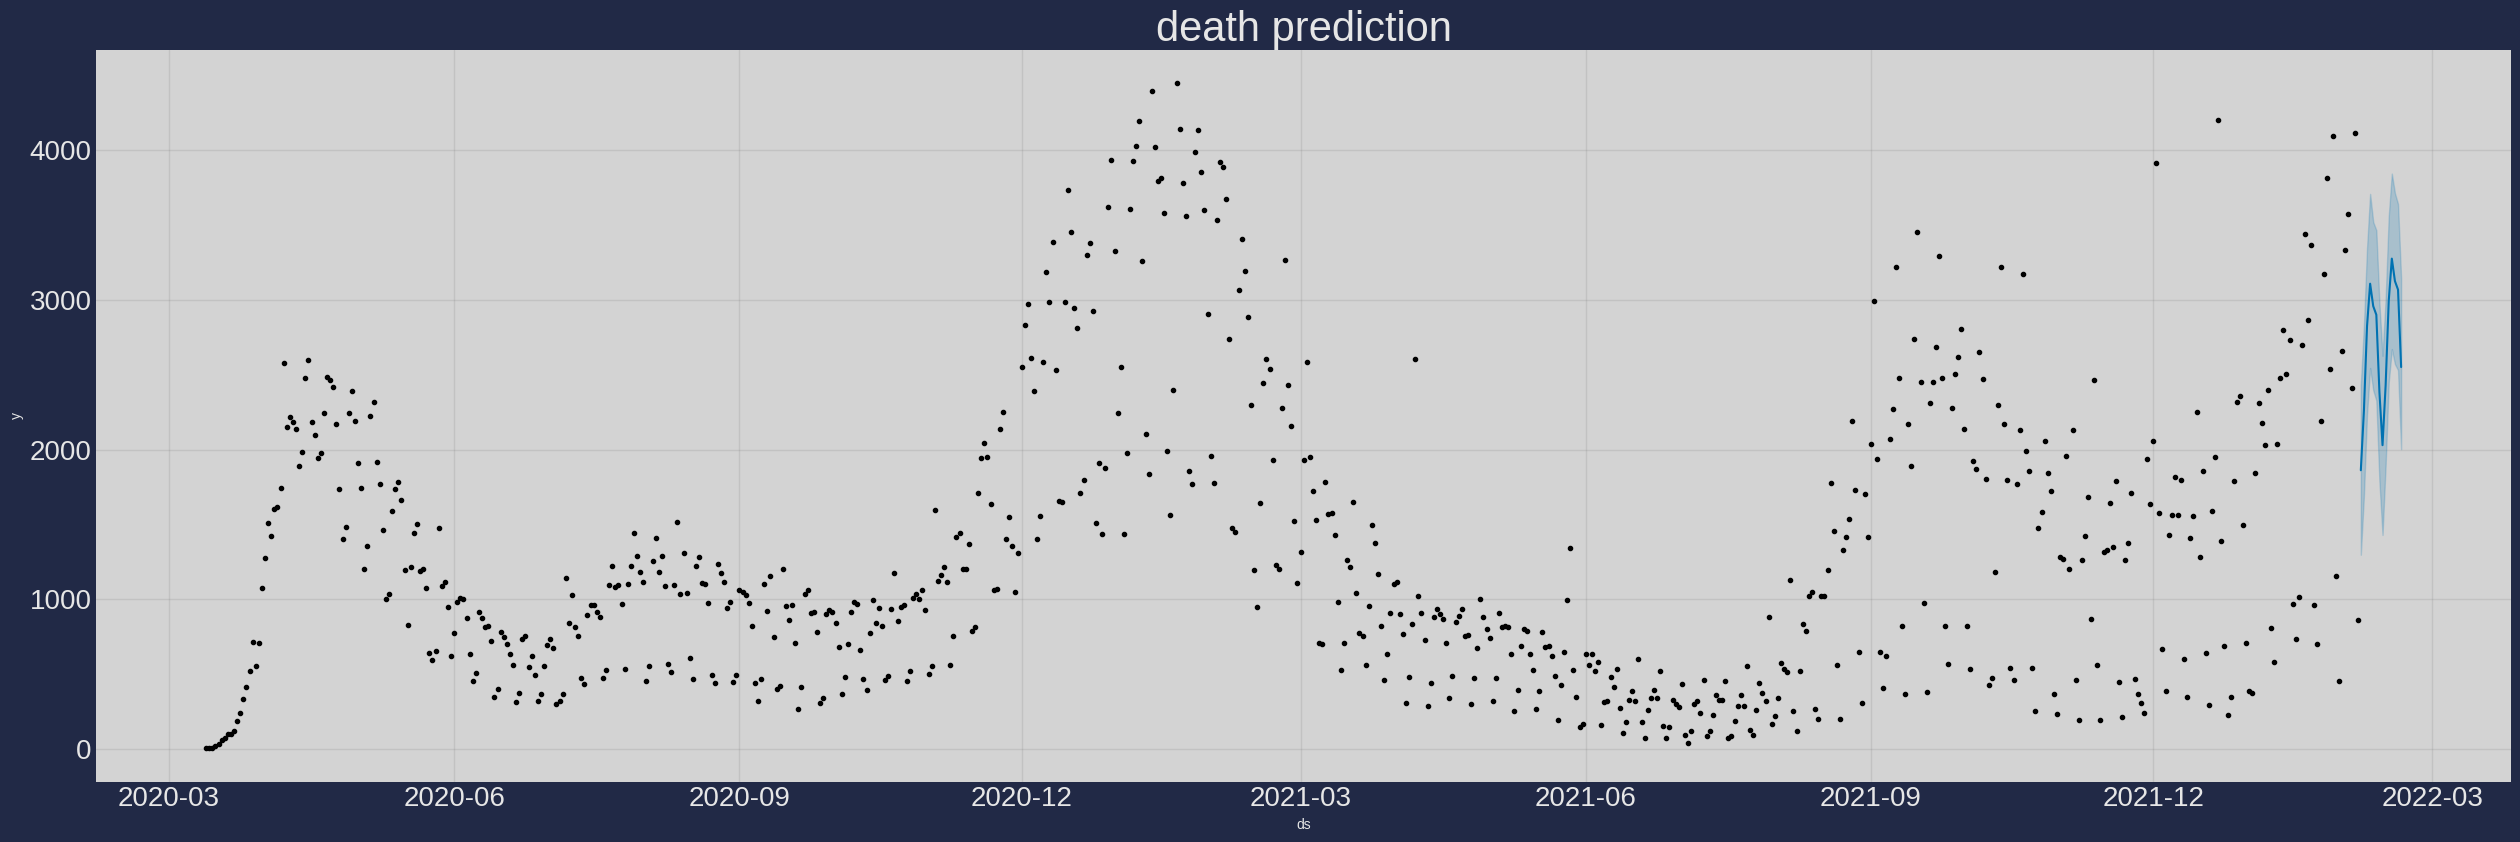

In [100]:
# Setup and train model
model = Prophet(n_changepoints=100,
            changepoint_prior_scale=0.5,
            changepoint_range=0.95,
            weekly_seasonality=7)
model.fit(data_train)
data_test_fcst = model.predict(df=data_test)
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(25)
fig = model.plot(data_test_fcst, ax=ax)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.title("death prediction", fontdict={'fontsize': 30})

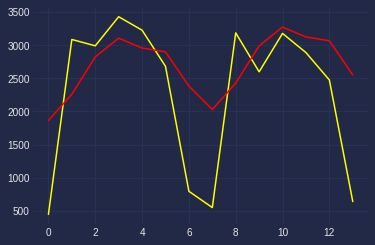

In [80]:
plt.style.use('cyberpunk')
data_test_fcst = model.predict(df=data_test)
pyplot.plot(data_test.y, color = 'yellow', label='test')  
pyplot.plot(data_test_fcst.yhat, color='red', label='pred')
pyplot.show()

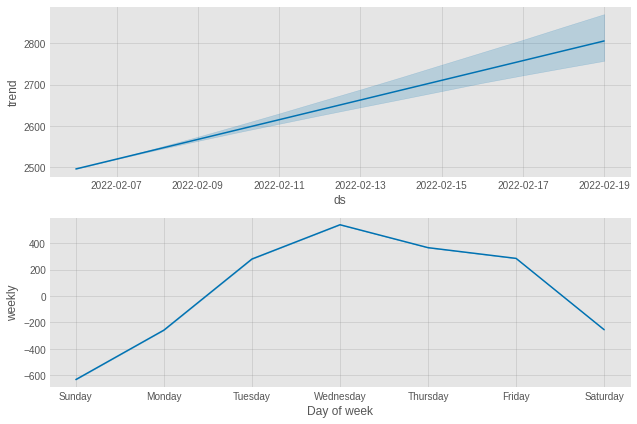

In [81]:
plt.style.use('ggplot')
fig2 = model.plot_components(data_test_fcst)

The MSE is very large 

In [82]:
mean_squared_error(data_test.y, data_test_fcst.yhat)**0.5

943.0905648106079

# Look at the autocorrelations and partial autocorrelation plots to tentatively identify the numbers of autoreregression terms that are needed in the Auto Regression Model

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,

  FutureWarning,



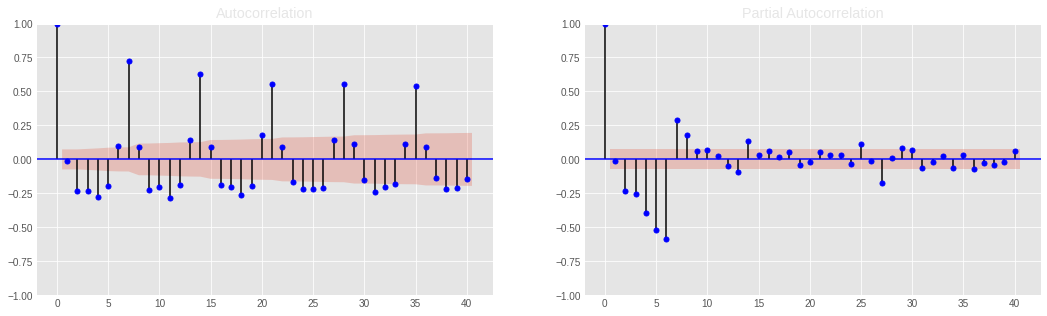

In [83]:
numveh = covidd["nums"]
n = len(numveh)-1
z = np.arange(n)
for i in range(1, n+1):
    #print(i)
    z[i-1] = numveh[i]-numveh[i-1]

plt.style.use('ggplot')
fig, ax = plt.subplots(1,2,figsize=(18,5))
sm.graphics.tsa.plot_acf(z, lags=40, ax=ax[0], color="blue", vlines_kwargs={"colors": "black"})
sm.graphics.tsa.plot_pacf(z, lags=40, ax=ax[1], color="blue")
plt.show()

# The model results presented that mose of the terms when we using 14 rolling obeservations have P-value < 0.05, we will use 14 terms in our model

In [104]:
train = covidd['nums'][:len(covidd)-14]
test = covidd['nums'][len(covidd)-14:]
armodel = AutoReg(train, lags=14).fit()
print(armodel.summary())

                            AutoReg Model Results                             
Dep. Variable:                   nums   No. Observations:                  695
Model:                    AutoReg(14)   Log Likelihood               -4975.377
Method:               Conditional MLE   S.D. of innovations            360.340
Date:                Sun, 13 Mar 2022   AIC                           9982.754
Time:                        19:57:53   BIC                          10055.131
Sample:                            14   HQIC                         10010.767
                                  695                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.2151     27.661      2.032      0.042       2.000     110.430
nums.L1        0.3873      0.038     10.132      0.000       0.312       0.462
nums.L2        0.0524      0.041      1.268      0.2

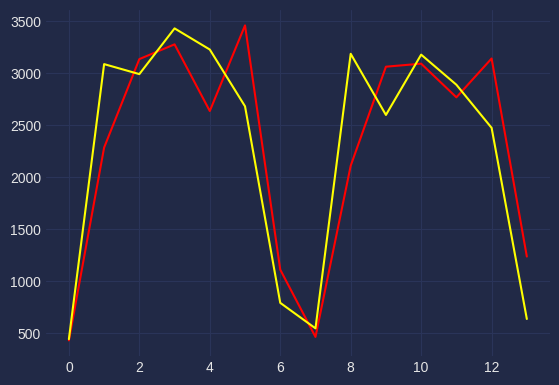

In [105]:
plt.style.use('cyberpunk')
pred = armodel.predict(start = len(train), end=(len(covidd)-1), dynamic=False)
t1_armodel= pd.DataFrame(pred)
t2_armodel= pd.DataFrame(test)
t1_armodel=t1_armodel.reset_index(drop=True)
t2_armodel=t2_armodel.reset_index(drop=True)
pyplot.plot(t1_armodel, color="red")
pyplot.plot(t2_armodel, color="yellow")

# The MSE improves a lot compare to the prophet model

In [106]:
mean_squared_error(test, pred)**0.5

530.5660886098924

# AR-Net model the simple autoregressive neural network for time series

In [107]:
data = covidd.groupby([pd.Grouper(key='index')]).first().reset_index()
data = data.set_index('index')
data = data.reset_index().rename(columns={'index':'ds', 'nums':'y'})
data['ds'] = data['ds'].dt.tz_localize(None)
df = data
df['nums_lag'] = df['y'].shift(14)
df.dropna()
df=df.iloc[20: , :]
df.tail(7)

,ds,y,nums_lag
702,2022-02-13,549.0,453.0
703,2022-02-14,3185.0,2660.0
704,2022-02-15,2598.0,3332.0
705,2022-02-16,3177.0,3568.0
706,2022-02-17,2888.0,2413.0
707,2022-02-18,2474.0,4112.0
708,2022-02-19,639.0,865.0


In [108]:
m = NeuralProphet(
    n_forecasts=14,
    n_lags=14, # n_lag using the 14-days period 
    learning_rate= 0.1,
)
m = m.add_lagged_regressor(names='nums_lag') #, only_last_value=True)
m.highlight_nth_step_ahead_of_each_forecast(3)
metrics = m.fit(df, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


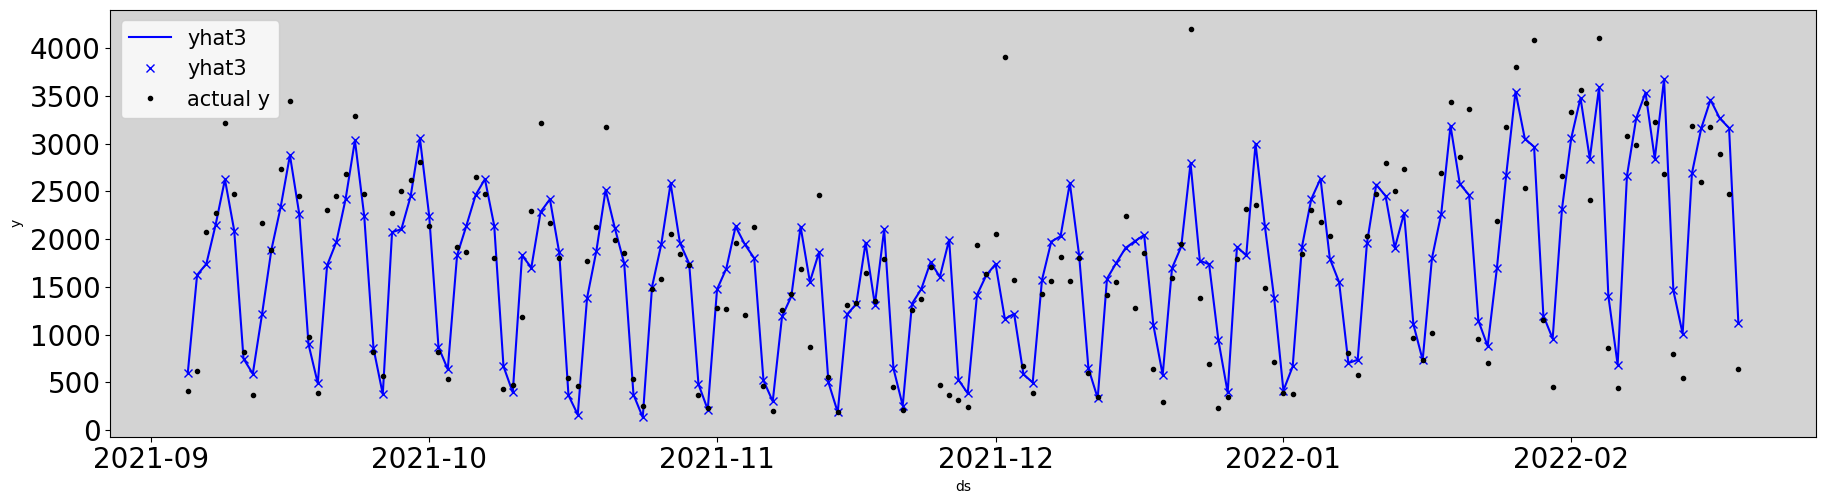

In [109]:
forecast = m.predict(df)
plt.style.use("default")
m.plot(forecast[-7*24:],figsize=(18,5))
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(loc=2, prop={'size': 15})
plt.grid()
plt.show()

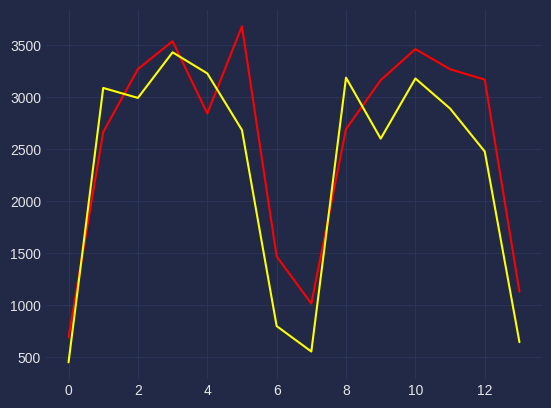

In [110]:
t1= forecast.yhat3[-14:]
t2= df[-14:].y
t1=t1.reset_index(drop=True)
t2=t2.reset_index(drop=True)
plt.style.use('cyberpunk')
pyplot.plot(t1, color="red")
pyplot.plot(t2, color="yellow")

In [111]:
mean_squared_error(t1, t2)**0.5 # MSE is similar as the Auto regessive model

509.4768950457732

# **Neural Prophet Model**

In [112]:
# define and fit model
#data_train = data_train.drop(['nums_lag'], axis=1)
set_random_seed(1234)
nm = NeuralProphet(n_changepoints=100,
                   daily_seasonality=False,                   
                   yearly_seasonality=False,
                   weekly_seasonality=7,
                   changepoints_range=0.9,
                   num_hidden_layers=1, # default: 0
                   seasonality_reg=1,
                   learning_rate = 0.01,
                   epochs = 100,
                   batch_size= 80,ar_sparsity=0.0001)
nm_result = nm.fit(data_train, freq='D')
future = nm.make_future_dataframe(data_test, periods = 7,
                                  n_historic_predictions=len(data_train))
forecast_2 = nm.predict(future)
print(len(forecast_2.dropna().yhat1))
mean_squared_error(forecast_2.dropna().y, forecast_2.dropna().yhat1)**0.5

INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO:NP.config:Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
Epoch[100/100]: 100%|██████████| 100/100 [00:02<00:00, 33.48it/s, SmoothL1Loss=0.0218, MAE=553, RMSE=702, RegLoss=0.0015]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 92.857% of the data.
INFO -

14


810.0950340215898

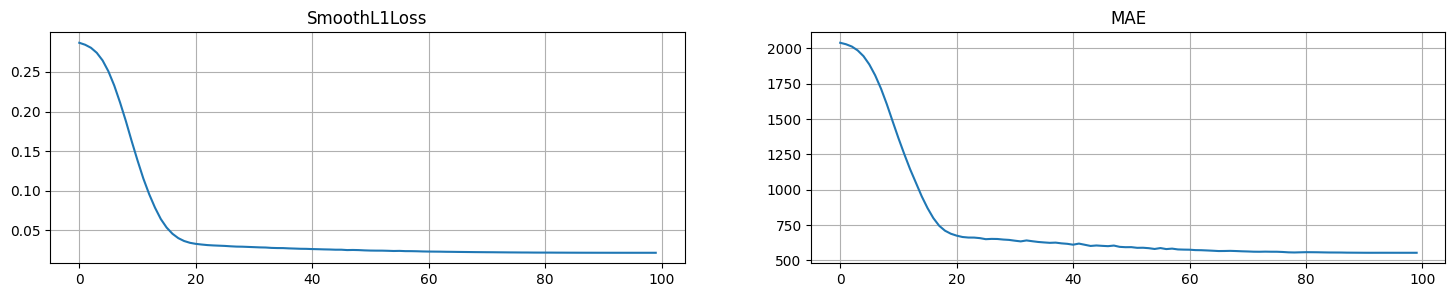

In [113]:
plt.style.use("default")
plt.rcParams['figure.figsize'] = (18, 3) # resize plot window
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(nm_result.SmoothL1Loss)
ax1.set_title('SmoothL1Loss')
ax1.grid()
ax2.plot(nm_result.MAE)
ax2.set_title('MAE')
ax2.grid()
plt.show()

In [114]:
future = nm.make_future_dataframe(data_test, periods = 7,
                                  n_historic_predictions=len(data_train))
forecast_2 = nm.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 92.857% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 92.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 695 historic forecasts, reduced to 14.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.238% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 95.238% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.238% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 95.238% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major fre

In [115]:
mean_squared_error(forecast_2.dropna().y, forecast_2.dropna().yhat1)**0.5

810.0950340215898

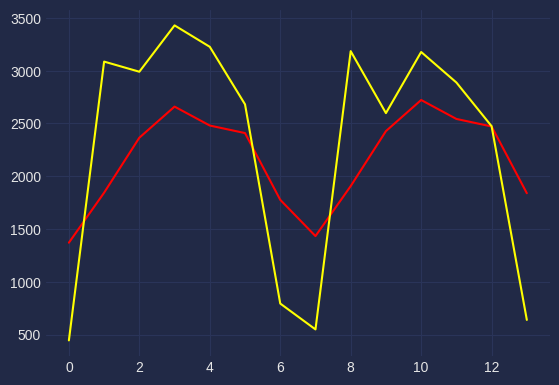

In [116]:
plt.style.use('cyberpunk')
plt.rcParams["figure.figsize"] = (6.5,4.5)
pyplot.plot(forecast_2.dropna().yhat1, color="red")
pyplot.plot(forecast_2.dropna().y, color="yellow")

# **ARMIA model**

In [97]:
#covidd= covidd.drop('nums_lag', axis=1)

In [117]:
covidd.head()

,index,nums
0,2020-03-13,7.0
1,2020-03-14,9.0
2,2020-03-15,11.0
3,2020-03-16,25.0
4,2020-03-17,36.0


In [118]:
covidd.shape

(709, 2)

In [119]:
covidd.set_index('index', inplace=True)
train = covidd.iloc[:len(covidd)-14, :].values
test = covidd.iloc[len(covidd)-14:, :].values
len(test)

14

In [120]:
import warnings
warnings.filterwarnings('ignore')

In [121]:
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    try:
        model = sm.tsa.arima.ARIMA(history, order=(7,1,2))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    except (ValueError, np.linalg.LinAlgError):
        pass
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rmse = mean_squared_error(test, predictions)**0.5
print('Test MSE: %.3f' % rmse)

Test MSE: 438.703


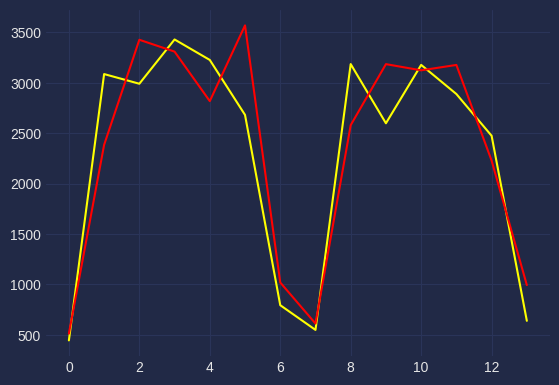

In [122]:
pyplot.plot(test, color = 'yellow', label='test')   
pyplot.plot(predictions, color='red', label='pred')
pyplot.show()

In [123]:
mean_squared_error(test, predictions)**0.5 ## MSE is the smallest 

438.7033747417726

# Summary all those models:
#1, Prophet;
#2, armodel;
#3, AR-net;
#4, Neural Prophet;
#5, ARMIA 

In [128]:
#plt.style.use('ggplot')
#fig, ax = plt.subplots(1,2,figsize=(18,5))
#sm.graphics.tsa.plot_acf(z, lags=40, ax=ax[0], color="blue", vlines_kwargs={"colors": "black"})
#sm.graphics.tsa.plot_pacf(z, lags=40, ax=ax[1], color="blue")
#plt.show()#

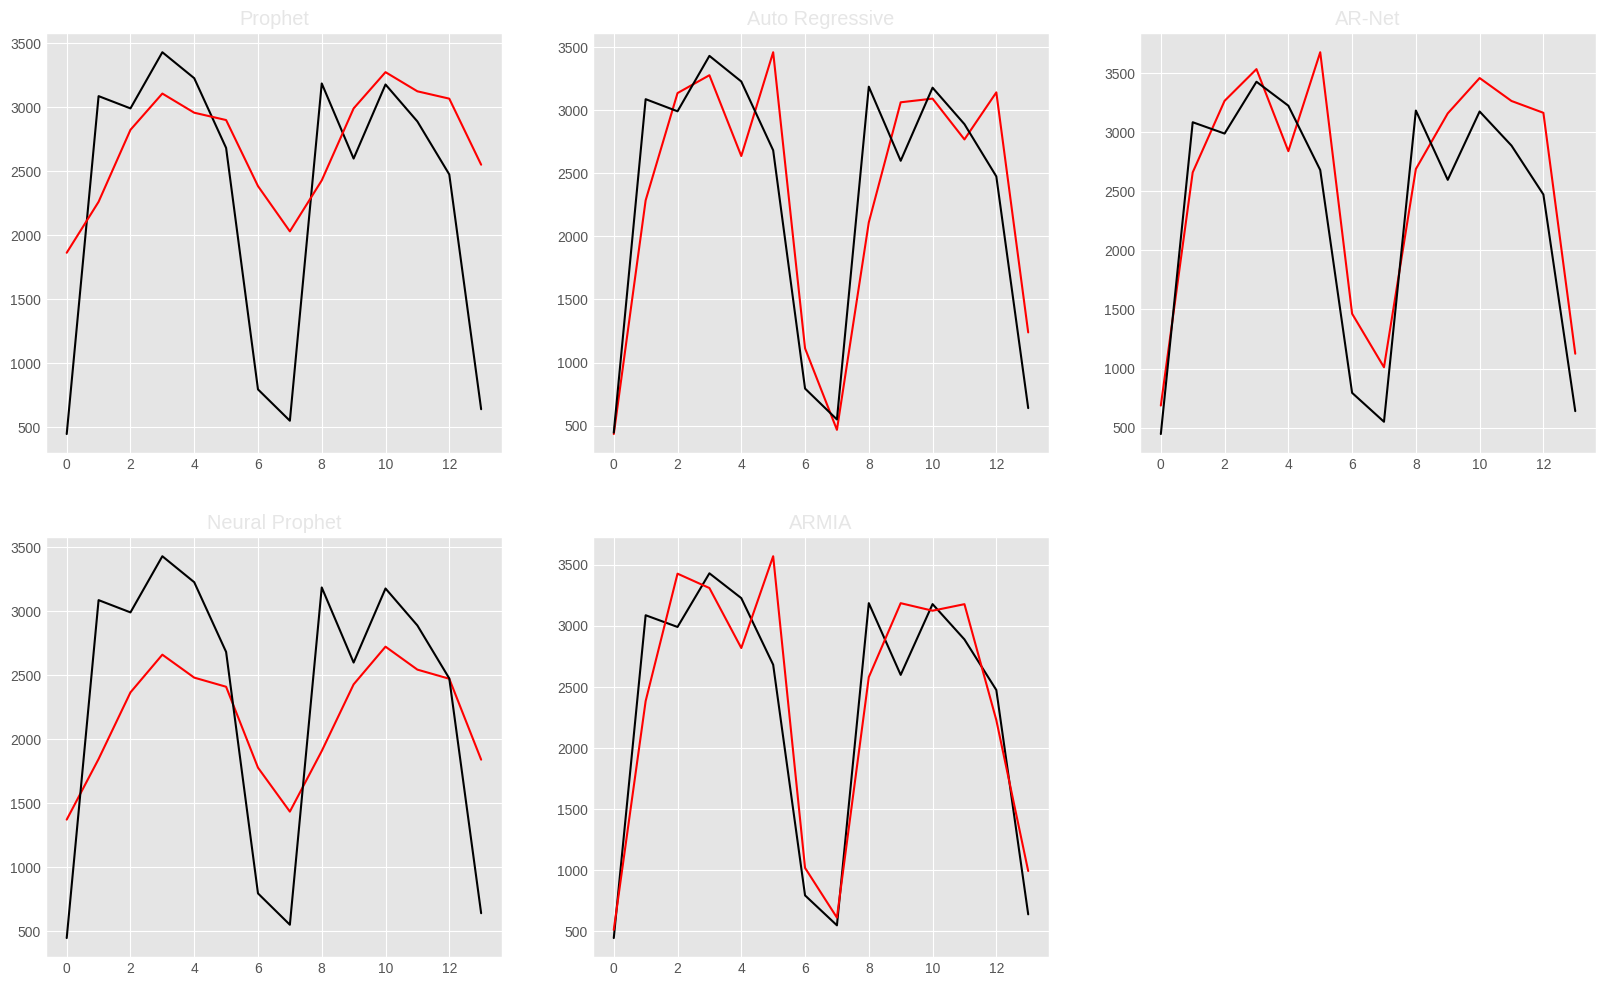

In [125]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(20,12))
#  subplot #1
plt.subplot(231)
plt.title('Prophet')
pyplot.plot(data_test.y, color = 'black', label='test')  
pyplot.plot(data_test_fcst.yhat, color='red', label='pred')
#  subplot #2
plt.subplot(2,3,2)
plt.title('Auto Regressive')
pyplot.plot(t1_armodel, color="red")
pyplot.plot(t2_armodel, color="black")
#  subplot #3
plt.subplot(233)
plt.title('AR-Net')
pyplot.plot(t1, color="red")
pyplot.plot(t2, color="black")
#  subplot #4
plt.subplot(2,3,4)
plt.title('Neural Prophet')
pyplot.plot(forecast_2.dropna().yhat1, color="red")
pyplot.plot(forecast_2.dropna().y, color="black")
#  subplot #5
plt.subplot(235)
plt.title('ARMIA')
pyplot.plot(test, color = 'black', label='test')   
pyplot.plot(predictions, color='red', label='pred')
plt.show()

In [126]:
RMSE = [0]* 5 
RMSE[0] = mean_squared_error(data_test.y, data_test_fcst.yhat)**0.5
RMSE[1] = mean_squared_error(test, pred)**0.5
RMSE[2] = mean_squared_error(t1, t2)**0.5
RMSE[3] = mean_squared_error(forecast_2.dropna().y, forecast_2.dropna().yhat1)**0.5
RMSE[4] = mean_squared_error(test, predictions)**0.5

finalRMSE = pd.DataFrame(RMSE)
model=['Prophet', 'Auto Regressive', 'AR-Net', 'Neural Prophet','ARMIA']
finalRMSE['model'] = model

In [127]:
print(finalRMSE) # ARMIA performs best 

            0            model
0  943.090565          Prophet
1  530.566089  Auto Regressive
2  509.476895           AR-Net
3  810.095034   Neural Prophet
4  438.703375            ARMIA
